<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [290]:
import time
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE
from scipy.stats import ks_2samp
import numpy as np
import seaborn as sns

In [291]:
t_init = time.time()

In [265]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

# 0 | Préparation des données

In [266]:
data = pd.read_csv(folder_path + "olist_customer_cleaned_data.csv")
monetary_and_frequency_outliers = pd.read_csv(folder_path + "olist_customer_monetary_frequency_outliers.csv")
monetary_only_outliers = pd.read_csv(folder_path + "olist_customer_monetary_outliers.csv")
frequency_only_outliers = pd.read_csv(folder_path + "olist_customer_frequency_outliers.csv")

In [267]:
outliers_df = pd.concat([monetary_and_frequency_outliers, monetary_only_outliers])
data = pd.concat([data, outliers_df])

In [268]:
data

,customer_unique_id,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,first_purch_at,last_purch_at,last_purch_day_of_week,customer_zip_code_prefix,rfm_segment_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,111,0.0,4.955123,8,413,5.0,1.0,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,3,7787,top (Gold)
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,0.0,3.302849,6,411,4.0,1.0,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,6053,risk (bronze)
2,0000f46a3911fa3c0805444483337064,536,0.0,4.456902,4,112,3.0,1.0,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,4,88115,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,320,0.0,3.775516,4,211,4.0,1.0,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,3,66812,inactive
4,0004aac84e0df4da2b147fca70cf8255,287,0.0,5.282645,7,214,5.0,1.0,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,1,18040,good (silver)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,ff6c9c45f6cee4ec0785650b18322d73,41,0.0,7.358015,9,414,5.0,1.0,1.0,2018-07-18 17:59:55,2018-07-18 17:59:55,2,14810,top (Gold)
1155,ff8eddc3ff272a5724e2ac6635cb7df2,59,0.0,6.899461,9,414,3.0,2.0,2.0,2018-07-01 10:38:02,2018-07-01 10:38:02,6,78600,top (Gold)
1156,ffba9f9dff87b05e310ecc46c8591044,547,0.0,7.394389,6,114,5.0,1.0,1.0,2017-02-27 15:39:41,2017-02-27 15:39:41,0,68695,risk (bronze)
1157,fff5eb4918b2bf4b2da476788d42051c,57,0.0,7.953304,9,414,5.0,6.0,1.0,2018-07-02 16:39:59,2018-07-02 16:39:59,0,58407,top (Gold)


In [269]:
data.describe()

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,last_purch_day_of_week,customer_zip_code_prefix
count,91020.000000,91020.000000,91020.000000,91020.000000,91020.000000,91020.000000,91020.000000,91020.000000,91020.000000,91020.000000
mean,237.309163,0.004365,4.707755,5.974028,264.152900,4.124672,1.139150,1.036754,2.754318,35290.363645
std,152.784433,0.064381,0.830409,1.617741,111.837448,1.324214,0.530131,0.221086,1.967339,29840.464930
min,0.000000,0.000000,2.260721,3.000000,111.000000,0.000000,1.000000,1.000000,0.000000,1003.000000
25%,113.000000,0.000000,4.130676,5.000000,211.000000,4.000000,1.000000,1.000000,1.000000,11432.000000
50%,218.000000,0.000000,4.664194,6.000000,311.000000,5.000000,1.000000,1.000000,3.000000,24722.000000
75%,346.000000,0.000000,5.183299,7.000000,411.000000,5.000000,1.000000,1.000000,4.000000,59091.000000
max,694.000000,2.708050,9.832181,12.000000,444.000000,5.000000,21.000000,8.000000,6.000000,99980.000000


# 1 | Standardisation des données

In [270]:
num_cols = ['recency', 'frequency', 'monetary', 'satisfaction', 'nbre_items', 'distinct_products']
ss = StandardScaler()
X_scaled = data.copy()

In [271]:
X_scaled[num_cols] = ss.fit_transform(X_scaled[num_cols])
X_scaled.head()

,customer_unique_id,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,first_purch_at,last_purch_at,last_purch_day_of_week,customer_zip_code_prefix,rfm_segment_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.826719,-0.067794,0.297888,8,413,0.661021,-0.262484,-0.166246,2018-05-10 10:56:27,2018-05-10 10:56:27,3,7787,top (Gold)
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.807084,-0.067794,-1.691833,6,411,-0.094148,-0.262484,-0.166246,2018-05-07 11:11:27,2018-05-07 11:11:27,0,6053,risk (bronze)
2,0000f46a3911fa3c0805444483337064,1.954993,-0.067794,-0.302085,4,112,-0.849318,-0.262484,-0.166246,2017-03-10 21:05:03,2017-03-10 21:05:03,4,88115,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,0.541229,-0.067794,-1.122633,4,211,-0.094148,-0.262484,-0.166246,2017-10-12 20:29:41,2017-10-12 20:29:41,3,66812,inactive
4,0004aac84e0df4da2b147fca70cf8255,0.325237,-0.067794,0.692301,7,214,0.661021,-0.262484,-0.166246,2017-11-14 19:45:42,2017-11-14 19:45:42,1,18040,good (silver)


In [272]:
rfm_feats = ['recency', 'frequency', 'monetary']

# 2 | Simulation de l'évolution de la stabilité du clustering

Pour suivre la stabilité du clustering dans le temps, nous allons :
- Découper nos données par périodes (par exemple, par mois ou par trimestre).  
- Recalculer le clustering pour chaque période avec les mêmes paramètres.
- Comparer les affectations des clusters de chaque période avec le clustering final via l’Adjusted Rand Index (ARI).
- Étudier l’évolution des distributions de nos features à l’aide d’un test de Kolmogorov-Smirnov (KS).


In [273]:
X_scaled.first_purch_at = pd.to_datetime(X_scaled.first_purch_at)
X_scaled.last_purch_at = pd.to_datetime(X_scaled.last_purch_at)

In [274]:
start_date = min(X_scaled.first_purch_at) # Correspond à la premiére commande dans l'ensemble de notre dataset
end_date = max(X_scaled.last_purch_at) # Correspond à la derniére commande dans l'ensemble de notre dataset
print("First order ever", start_date)
print("Last order", end_date)

First order ever 2016-10-03 16:56:50
Last order 2018-08-29 15:00:37


In [275]:
# Calcul des periodes
periods = (end_date - start_date).days
print(f"L'ensemble de nos données s'étale sur {periods} jours, soit {periods / 365} années, soit en moyenne {periods / 30.4} mois.")

L'ensemble de nos données s'étale sur 694 jours, soit 1.9013698630136986 années, soit en moyenne 22.828947368421055 mois.


In [276]:
# Nous prenderons les 12 premiers mois comme données de reference pour construire le modéle Kmean de reference
ref_date = start_date + pd.DateOffset(months=12)
print(f"La date de reference correspond au {ref_date}")

La date de reference correspond au 2017-10-03 16:56:50


In [277]:
# Liste des dates d'analyse : chaque premier du mois à partir du mois suivant la référence
months = pd.date_range(start=ref_date, end=end_date, freq='MS')

print(f"Il y a {len(months)} mois à analyser:")
print("\n".join([str(m) for m in months]))

Il y a 10 mois à analyser:
2017-11-01 16:56:50
2017-12-01 16:56:50
2018-01-01 16:56:50
2018-02-01 16:56:50
2018-03-01 16:56:50
2018-04-01 16:56:50
2018-05-01 16:56:50
2018-06-01 16:56:50
2018-07-01 16:56:50
2018-08-01 16:56:50


In [278]:
# Fonction pour filtrer par rapport à une date donnée
def compute_rfm(df, current_date):
    df_period = df[df.first_purch_at <= current_date]

    rfm = df_period[rfm_feats].copy()
    rfm.loc[:,'customer_unique_id'] = df_period.customer_unique_id
    return rfm

# 3 | Calcul du modèle de référence

In [279]:
rfm_ref = compute_rfm(X_scaled, ref_date)

n_clusters = 6

# Clustering sur le modèle de référence
kmeans_ref = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_ref.fit(rfm_ref[rfm_feats])
rfm_ref["cluster"] = kmeans_ref.labels_

In [280]:
rfm_ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24988 entries, 2 to 1158
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   recency             24988 non-null  float64
 1   frequency           24988 non-null  float64
 2   monetary            24988 non-null  float64
 3   customer_unique_id  24988 non-null  object 
 4   cluster             24988 non-null  int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 1.0+ MB


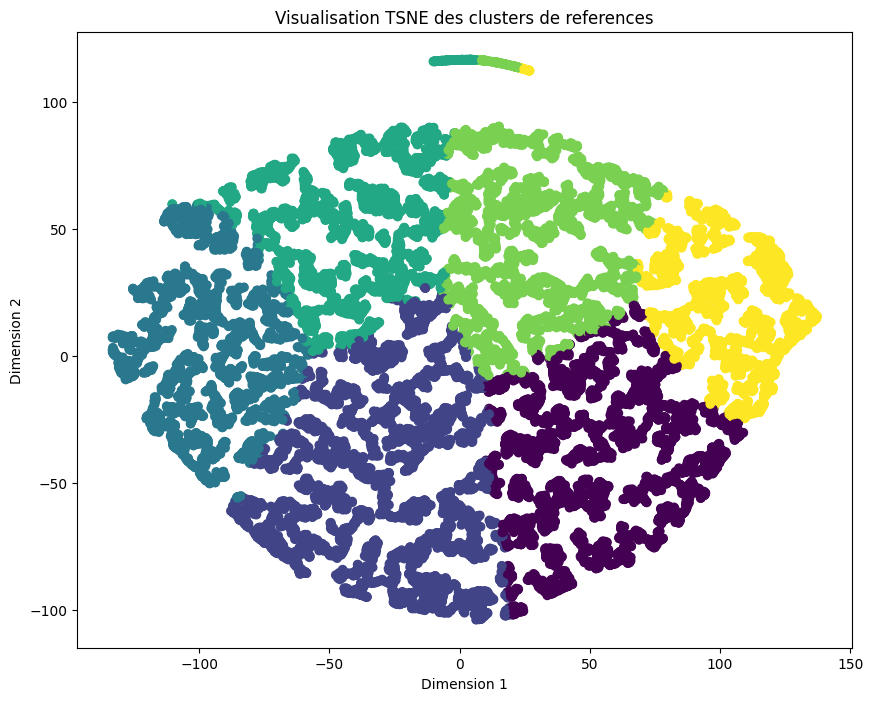

CPU times: user 5min 15s, sys: 456 ms, total: 5min 15s
Wall time: 5min 16s


In [71]:
%%time
tsne = TSNE(n_components=2, random_state=42)
rfm_ref_tsne = tsne.fit_transform(rfm_ref[rfm_feats])

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(rfm_ref_tsne[:, 0], rfm_ref_tsne[:, 1], c=rfm_ref["cluster"], cmap="viridis")
ax.set_title("Visualisation TSNE des clusters de references")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
plt.show()

# 4 | Suivi mensuel du clustering

Pour chaque mois postérieur à la date de référence, nous recalculons le clustering et comparons le résultat au modèle de référence via l’ARI.

Le score ARI (Adjusted Rand Index) mesure la similarité entre le clustering de référence et le clustering recalculé à chaque période. Un ARI proche de 1 indique des clusters presque identiques, alors qu’un ARI proche de 0 (voire négatif) indique des clusters très différents.

Nous fixerons un seuil de **ARI = 0.7**

In [281]:
ari_scores = {}

for current_date in months:
    rfm_current = compute_rfm(X_scaled, current_date)

    # Recalculer le clustering pour la période courante
    kmeans_current = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_current.fit(rfm_current[rfm_feats])

    # Ne garder que les clients présents dans le modèle de référence pour comparaison
    common_customers = rfm_ref[rfm_ref.customer_unique_id.isin(list(rfm_current.customer_unique_id))]

    if len(common_customers) == 0:
        continue

    rfm_current["cluster"] = kmeans_current.labels_
    rfm_current = rfm_current[rfm_current.customer_unique_id.isin(list(common_customers.customer_unique_id))]

    # Calculer l'ARI entre le clustering de référence et celui de la période courante
    ari = adjusted_rand_score(rfm_ref.cluster, rfm_current["cluster"])
    ari_scores[current_date.strftime("%Y-%m")] = ari

In [282]:
ari_scores

{'2017-11': 0.38421164262536234,
 '2017-12': 0.6153315591734563,
 '2018-01': 0.4589521529375073,
 '2018-02': 0.35480832158976167,
 '2018-03': 0.25451837582954034,
 '2018-04': 0.21739235338538873,
 '2018-05': 0.2035892166545733,
 '2018-06': 0.2593415847913287,
 '2018-07': 0.3164535845508019,
 '2018-08': 0.28320787893225174}

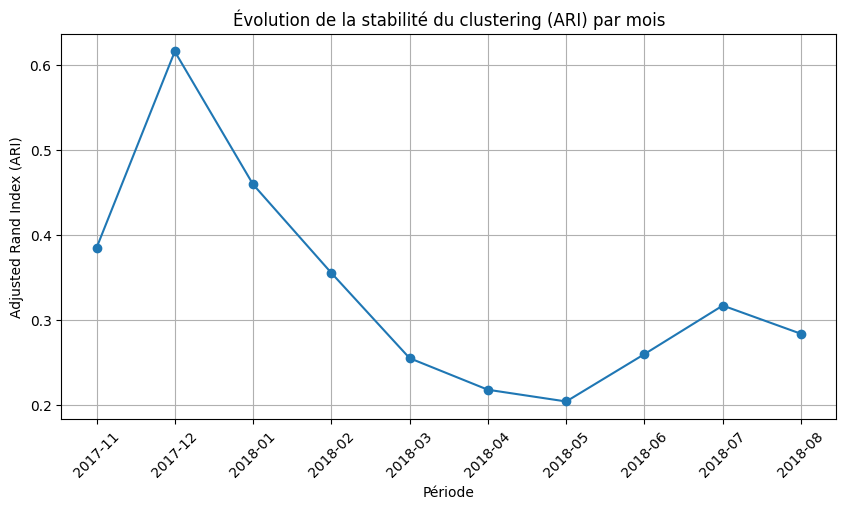

In [283]:
plt.figure(figsize=(10, 5))
plt.plot(list(ari_scores.keys()), list(ari_scores.values()), marker="o", linestyle='-')
plt.title("Évolution de la stabilité du clustering (ARI) par mois")
plt.xlabel("Période")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Sur le graphique :

- Novembre 2017 (2017-11) : L’ARI est autour de 0.8, indiquant une forte similarité avec le modèle de référence.
- Décembre 2017 à Janvier 2018 : L’ARI chute rapidement sous 0.4.


Nous constatons que le l'indice Rand ajusté baisse significativement après deux mois de données supplémentaires. Il sera donc nécessaire de revoir le clustering deux mois après sa mise en production.

# 5 | Suivi de l'évolution des distributions des variables RFM

## 5.1 | Visualisation des distributions

In [285]:
df = X_scaled.copy()

# Create a new 'month' column and assign values based on first_purch_at
df['month'] = pd.cut(
    df['first_purch_at'],
    bins=[
        pd.Timestamp.min,
        ref_date,
        ref_date + pd.DateOffset(months=1),
        ref_date + pd.DateOffset(months=2),
        ref_date + pd.DateOffset(months=3),
        pd.Timestamp.max
    ],
    labels=['reference', '+1 months', '+2 months', '+3 months', 'later'],
    right=False,
    include_lowest=True
)

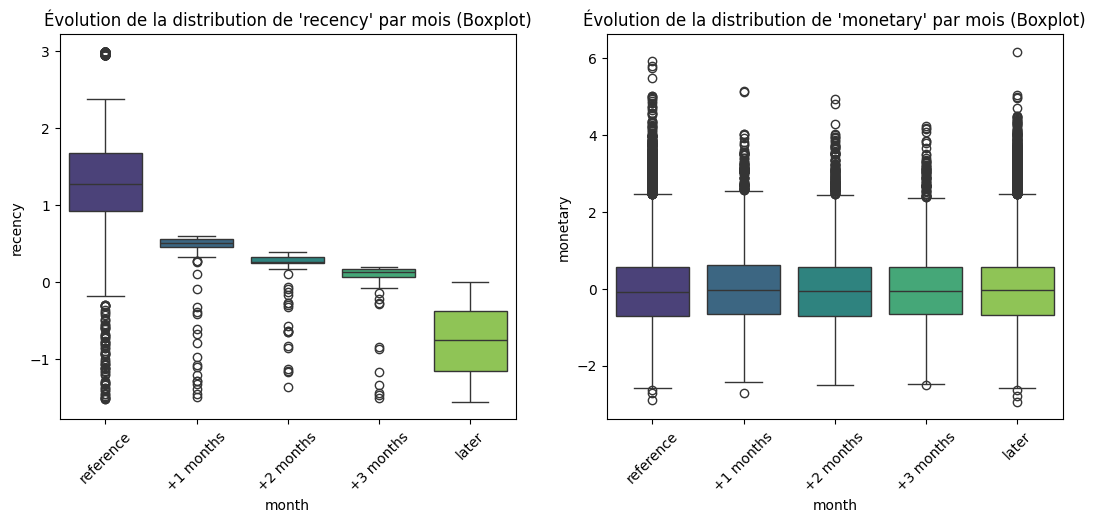

In [289]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1)
sns.boxplot(x='month', y='recency', data=df, palette='viridis', hue='month', ax=ax1)
plt.title("Évolution de la distribution de 'recency' par mois (Boxplot)")
plt.xticks(rotation=45)

ax2 = fig.add_subplot(1, 3, 2)
sns.boxplot(x='month', y='monetary', data=df, palette='viridis', hue='month', ax=ax2)
ax2.set_title("Évolution de la distribution de 'monetary' par mois (Boxplot)")
plt.xticks(rotation=45)

plt.show()

## 5.2 | Test statistque de Kolmogorov-Smirnov

Ici, nous effectuerons un test de Kolmogorov-Smirnov pour l'ensemble de nos features
- Hypothèse 0: les deux distributions sont identiques
- Hypothèse 1: il existe une différence significative entre les deux distributions.

In [300]:
second_month_period = months[1]
rfm_second_month= compute_rfm(X_scaled, second_month_period)
# Conserver uniquement les clients communs
common_customers = rfm_ref.index.intersection(rfm_last.index)
rfm_last = rfm_last.loc[common_customers]

# Test KS sur les variables rfm
for feature in rfm_feats:
  ks_stat, p_value = ks_2samp(rfm_ref.loc[common_customers, feature], rfm_last[feature])
  print(f"Test KS pour {feature} entre le modèle de référence et la période {second_month_period.strftime('%Y-%m')}:")
  print(f"Statistique KS = {ks_stat:.3f}, p-value = {p_value:.3f}")
  if p_value < 0.05:
    print("L'hypothèse nulle est rejetée, il existe une différence significative entre les distributions.")
  else:
    print("L'hypothèse nulle est acceptée, il n'y a pas de différence significative entre les distributions.")
  print("---"*9)

Test KS pour recency entre le modèle de référence et la période 2017-12:
Statistique KS = 0.030, p-value = 0.000
L'hypothèse nulle est rejetée, il existe une différence significative entre les distributions.
---------------------------
Test KS pour frequency entre le modèle de référence et la période 2017-12:
Statistique KS = 0.005, p-value = 0.905
L'hypothèse nulle est acceptée, il n'y a pas de différence significative entre les distributions.
---------------------------
Test KS pour monetary entre le modèle de référence et la période 2017-12:
Statistique KS = 0.016, p-value = 0.002
L'hypothèse nulle est rejetée, il existe une différence significative entre les distributions.
---------------------------


- Recency et monetary ayant significativement évolué, le modèle de clustering initial (basé sur la distribution de référence) pourrait ne plus refléter parfaitement la réalité de décembre 2017.
- La frequency restant stable, il se peut que les clients achètent autant de fois, mais à des intervalles différents ou avec des montants différents.

# 6 | Recommendation

Au vu de la forte chute de l’ARI dès le deuxième mois et des changements significatifs observés dans la distribution de certaines variables (notamment *recency* et *monetary*), il apparaît qu’un réentraînement du modèle de clustering tous les **deux mois** est judicieux. Cette fréquence de mise à jour permet de conserver une segmentation pertinente, en phase avec l’évolution rapide du comportement client, tout en évitant un recalcul trop fréquent et coûteux. Ainsi, nous pourrons maintenir une vision fiable des groupes de clients et agir en conséquence (campagnes marketing, relances ciblées, etc.) en s'assurant que la structure des clusters reflète toujours la réalité la plus récente.

In [288]:
t_final = time.time()
print(f"La durée d'execution compléte du notebook est de: {t_final - t_init} secondes")

La durée d'execution compléte du notebook est de: 9.316324472427368 secondes


# FIN